In [108]:
include("../src/HPFEM.jl")

HPFEM

In [109]:
nel = 2
nnodes = nel + 1
idir = Int[]#1,nnodes]
M = 3
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir, true);


In [110]:
uexact(x) = sin(x)
rhsfun(x) = 2*sin(x)


rhsfun (generic function with 1 method)

In [111]:
a = 1.0π
b = 3.0π
nodes = [a; a + (a+b)/3; b]#collect(linspace(a, b, nnodes));

In [112]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [113]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymTriP);

In [114]:
for e = 1:nel
    Ae = zeros(M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [115]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
#Fe[1,1] = uexact(a);
#Fe[2,nel] = uexact(b);

In [116]:
HPFEM.solve!(solver, Fe);

In [117]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

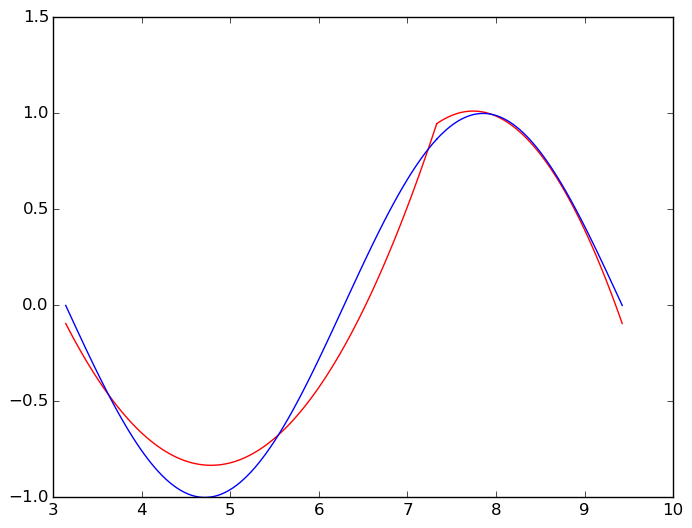

0.24018293845743857

In [118]:
using PyPlot
maxerr = 0.0
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr

In [119]:
Ue[1,1]

-0.09419295119144218

In [99]:
Ue[2,2]

0.03807390548906536

In [100]:
dof.bmap

2x2 Array{Int64,2}:
 1  2
 2  1

In [106]:
dof.map

3x2 Array{Int64,2}:
 1  2
 2  1
 3  4

In [107]:
Fe

3x2 Array{Float64,2}:
  5.04504e-16  -5.04504e-16
 -5.04504e-16   5.04504e-16
 -3.84585       3.84585    